# Geometry of Acoustic Space

## Load Packages

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from pyAudioAnalysis import audioBasicIO
from pyAudioAnalysis import ShortTermFeatures
from pyAudioAnalysis import MidTermFeatures
from soundsig.sound import BioSound 
from soundsig.sound import WavFile

import matplotlib.pyplot as plt
from scipy.io import wavfile
from spafe.features.lfcc import lfcc
from scipy.spatial import distance
from sklearn.decomposition import PCA
from sklearn.preprocessing import normalize
from sklearn.preprocessing import MinMaxScaler

import os
import sys
import h5py
import warnings
warnings.filterwarnings("ignore")

<frozen importlib._bootstrap>:219: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject
C:\Users\Dell\anaconda3\lib\site-packages\pydub\utils.py:170: RuntimeWarning: Couldn't find ffmpeg or avconv - defaulting to ffmpeg, but may not work
  warn("Couldn't find ffmpeg or avconv - defaulting to ffmpeg, but may not work", RuntimeWarning)


## Load Data

In [2]:
data_root = os.path.join('..', '..', 'data', 'anesthetized')
data_root

'..\\..\\data\\anesthetized'

In [3]:
df = pd.read_csv('aa-4.csv')
df.sample(n=5)

,subject,site,single_unit,sortType,stim_number,original_wavfile,callerAge,callid,stim_duration,stim_source,stim_source_sex,stim_type,brain_region,hemisphere,vocid,auditory_cortex
26059,GreBlu9508M,Site2,Site2_L1100R1450_e31_s0_ss1,single,119,BlaLbl8026_FAS_Ne_3-10-6.wav,A,Ne,2.500000,unfamiliar,f,call,NCM,R,Ne,A2
97164,YelBlu6903F,Site4,Site4_L1500R1500_e17_s0_ss3,single,47,BlaBla0506_MAF_Ne_9-5-4.wav,A,Ne,2.500000,familiar,m,call,NCM,R,Ne,A2
19454,GreBlu9508M,Site1,Site1_L750R1100_e28_s0_ss1,single,114,BlaLbl8026_FAS_DC_9-5-3.wav,A,DC,2.500000,unfamiliar,f,call,CML,R,DC,A1
25336,GreBlu9508M,Site2,Site2_L1100R1450_e28_s0_ss1,single,116,BlaLbl8026_FAS_Di_2.wav,A,Di,0.417220,unfamiliar,f,call,L1-CML,R,Di,A1
8269,BlaBro09xxF,Site2,Site2_L2000R1600_e32_s1_ss2,single,89,STRFxx0000__So_3.wav,NaN,NaN,1.722045,unfamiliar,m,song,NCM,R,song,A2


## Analysis

In [4]:
subjects = df['subject'].unique()

In [13]:
def get_features(myBioSound):
    feature_vector = np.array([
                              # Pitch features
                              myBioSound.fund, myBioSound.meansal,
                              myBioSound.maxfund, myBioSound.minfund, myBioSound.cvfund,

                              # Shape of spectral envelope
                              myBioSound.meanspect, myBioSound.stdspect,
                              myBioSound.skewspect, myBioSound.kurtosisspect, myBioSound.entropyspect,
                              myBioSound.q1, myBioSound.q2, myBioSound.q3,

                              # Shape and magnitude of amplitude envelope
                              myBioSound.meantime, myBioSound.stdtime,
                              myBioSound.skewtime, myBioSound.kurtosistime, myBioSound.entropytime,
                              myBioSound.rms, myBioSound.maxAmp])
    feature_vector = np.reshape(feature_vector, (1, 20))
    return feature_vector

In [44]:
X, y = np.empty((0, 20)), np.array([])
for subject in subjects:
    h5files = os.listdir(os.path.join(data_root, subject, 'wavfiles', 'h5files'))
    h5files = [os.path.join(data_root, subject, 'wavfiles', 'h5files', f) for f in h5files]

    for h5file in h5files:
        myBioSound = BioSound()
        try:
            myBioSound.readh5(h5file)
        except:
            print('file not found')
            continue
        if myBioSound.type.tobytes().decode() == 'Wh':
            print('Wh')
            continue
        feature_vector = get_features(myBioSound)
        if feature_vector.dtype == np.dtype('O'):
            print('here')
            continue

        X = np.append(X, feature_vector, axis=0)
        y = np.append(y, myBioSound.type.tobytes().decode())

here
here


### PCA on Feature Vectors

In [45]:
pca = PCA(n_components=2)
scaler = MinMaxScaler()

In [58]:
X_norm = normalize(X, axis=0)    # axis=0 to normalize features
#X_norm = scaler.fit_transform(X)
X_comp = pca.fit_transform(X_norm)

In [47]:
y.shape

(183,)

<AxesSubplot:>

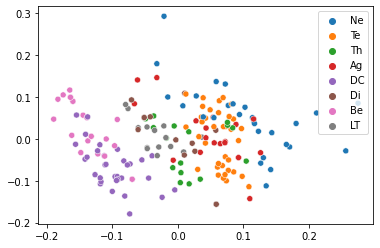

In [59]:
sns.scatterplot(x=X_comp[:, 0], y=X_comp[:, 1], hue=y)

In [49]:
pd.Series(y).value_counts()

Te    36
DC    32
Ne    28
Be    22
Ag    22
Th    16
LT    14
Di    13
dtype: int64

In [50]:
X.shape

(183, 20)

In [51]:
y.shape

(183,)

In [52]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()

In [53]:
X_transformed = scaler.fit_transform(X)

## Distance Matrix

In [54]:
def get_category_dist_matrix(X, y):
    unique_categories = np.unique(y)
    num_categories = len(unique_categories)
    dist_matrix = np.zeros((num_categories, num_categories))

    sample_labels = []
    category_indices = {}  # To keep track of the category indices and sample counts.
    
    # pick first category
    for i, cat_1 in enumerate(unique_categories):
        X_1 = X[y == cat_1]
        # pick second category
        for j, cat_2 in enumerate(unique_categories):
            X_2 = X[y == cat_2]
            dist_matrix[i, j] = distance.directed_hausdorff(X_1, X_2)[0]
        

    return dist_matrix

In [55]:
dist_matrix = get_category_dist_matrix(X_transformed, y)

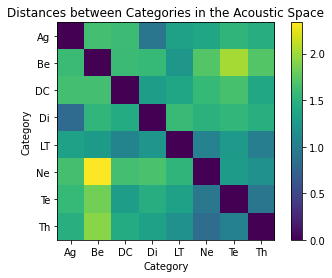

In [56]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial.distance import cdist

# Plot the distances as a heatmap
fig, ax = plt.subplots()
heatmap = ax.imshow(dist_matrix, cmap='viridis')

# Customize the plot
cats = np.unique(y)
ax.set_xticks(np.arange(len(cats)))
ax.set_yticks(np.arange(len(cats)))
ax.set_xticklabels(cats)
ax.set_yticklabels(cats)
plt.xlabel('Category')
plt.ylabel('Category')
plt.title('Distances between Categories in the Acoustic Space')
plt.colorbar(heatmap, ax=ax)

# Show the plot
plt.show()


In [57]:
with open('acoustic_representation.npy', 'wb') as f:
    np.save(f, dist_matrix)